In [1]:
import os
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
tf.test.is_gpu_available()

True

In [4]:
train_path="/kaggle/input/leaf-class-main-2/Train"
test_path="/kaggle/input/leafdiseaseclassification1/Valid"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [5]:
print(class_names)
print(class_names_test)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Bacterial_spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Grape___Black_rot', 'Potato___Early_blight', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___healthy']
['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Bacterial_spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Grape___Black_rot', 'Potato___Early_blight', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___healthy']


In [6]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory("/kaggle/input/leaf-class-main-2/Train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/kaggle/input/leafdiseaseclassification1/Valid",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')

Found 63080 images belonging to 17 classes.
Found 15768 images belonging to 17 classes.


In [8]:
# hyperparameter setting
image_size = 256
batch_size = 32
epochs = 25

In [9]:
# input files

base_dir='/kaggle/input/leaf-class-main-2/Train'

lable_list = os.listdir(base_dir)

dataset = []

for i in range(len(lable_list)):
  path = base_dir + '/' + lable_list[i]
  dataset.append(glob.glob(path + '/*'))
  print(f'{lable_list[i]} : {len(dataset[i])}')

Tomato___Late_blight : 3702
Tomato___healthy : 3852
Grape___healthy : 3384
Potato___healthy : 3648
Corn_(maize)___Northern_Leaf_Blight : 3816
Tomato___Early_blight : 3840
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 3284
Tomato___Bacterial_spot : 3404
Pepper,_bell___healthy : 3976
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 3444
Potato___Late_blight : 3878
Grape___Black_rot : 3776
Potato___Early_blight : 3878
Corn_(maize)___Common_rust_ : 3814
Grape___Esca_(Black_Measles) : 3840
Pepper,_bell___Bacterial_spot : 3826
Corn_(maize)___healthy : 3718


In [10]:
# add labels

def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

dataset_label = []

for i in range(len(lable_list)):
  files = add_labels(dataset[i], lable_list[i])
  dataset_label.append(files)
  print(dataset_label[i][0])

('/kaggle/input/leaf-class-main-2/Train/Tomato___Late_blight/781e93a9-2059-42de-8075-658033a6abf7___RS_Late.B 6075.JPG', 'Tomato___Late_blight')
('/kaggle/input/leaf-class-main-2/Train/Tomato___healthy/4a1e2b71-992a-4a64-a599-b49b8fa75378___RS_HL 0627.JPG', 'Tomato___healthy')
('/kaggle/input/leaf-class-main-2/Train/Grape___healthy/2dacf3f7-797b-4d4c-bf77-1d1a8f6d965d___Mt.N.V_HL 9117(1).JPG', 'Grape___healthy')
('/kaggle/input/leaf-class-main-2/Train/Potato___healthy/414f6249-9f78-4af5-9593-9d5a7e7d979f___RS_HL 1918_270deg(1).JPG', 'Potato___healthy')
('/kaggle/input/leaf-class-main-2/Train/Corn_(maize)___Northern_Leaf_Blight/c2e5ab9e-e705-4f13-9c50-1243e8ea0255___RS_NLB 3555_flipTB(1).JPG', 'Corn_(maize)___Northern_Leaf_Blight')
('/kaggle/input/leaf-class-main-2/Train/Tomato___Early_blight/24455ffa-8700-475c-8b4e-a7775f40ad3f___RS_Erly.B 8365_180deg(1).JPG', 'Tomato___Early_blight')
('/kaggle/input/leaf-class-main-2/Train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/527b87bb-91

In [11]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

dataset_data = []

for i in range(len(lable_list)):
  data = split_data(dataset_label[i])
  dataset_data.append(data)

In [12]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

for i in range(len(lable_list)):
  collect(dataset_data[i])
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

45562 8049 9469


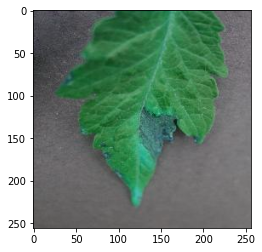

In [13]:
plt.figure()
image = cv2.imread(train_df['image'][0])
plt.imshow(image)

In [14]:
# build the model

# pretrained_model = MobileNet(input_shape=(image_size, image_size, 3),
#                          include_top=False,
#                          weights='imagenet')

# Initializing the CNN
model = Sequential()

# Convolution Step 1
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())

# Convolution Step 2
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())

# Convolution Step 3
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())

# Convolution Step 4
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())

# Convolution Step 5
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())

# Flattening Step
model.add(Flatten())

# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = 17, activation = 'softmax'))


# model.layers[0].trainable = False

In [15]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                  patience = 4, 
#                                  verbose=1,
#                                  factor=0.5, 
#                                  min_lr=0.00005)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [16]:
history = model.fit_generator(train_generator,
                              validation_data=test_generator,epochs=epochs,
                              callbacks=[es]) 

Epoch 1/25
1972/1972 [==============================] - 1185s 599ms/step - loss: 1.9293 - accuracy: 0.4256 - val_loss: 3.6427 - val_accuracy: 0.4087
Epoch 2/25
1972/1972 [==============================] - 761s 386ms/step - loss: 0.7183 - accuracy: 0.7601 - val_loss: 0.7103 - val_accuracy: 0.7608
Epoch 3/25
1972/1972 [==============================] - 767s 389ms/step - loss: 0.4900 - accuracy: 0.8378 - val_loss: 0.6032 - val_accuracy: 0.8380
Epoch 4/25
1972/1972 [==============================] - 751s 381ms/step - loss: 0.3756 - accuracy: 0.8768 - val_loss: 0.3167 - val_accuracy: 0.8968
Epoch 5/25
1972/1972 [==============================] - 772s 392ms/step - loss: 0.2964 - accuracy: 0.9023 - val_loss: 1.5236 - val_accuracy: 0.6531
Epoch 6/25
1972/1972 [==============================] - 767s 389ms/step - loss: 0.2432 - accuracy: 0.9199 - val_loss: 0.3702 - val_accuracy: 0.8922
Epoch 7/25
1972/1972 [==============================] - 773s 392ms/step - loss: 0.2072 - accuracy: 0.9300 - val

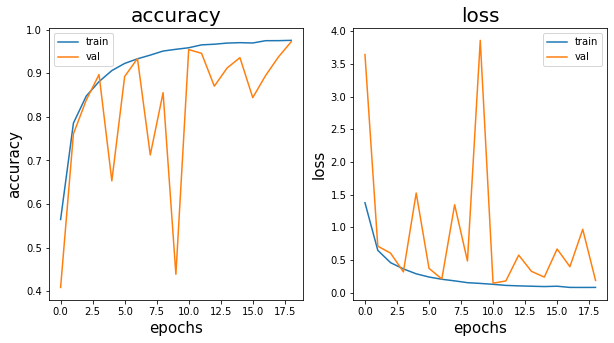

In [17]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

0 : Tomato___Late_blight
1 : Tomato___healthy
2 : Grape___healthy
3 : Potato___healthy
4 : Corn_(maize)___Northern_Leaf_Blight
5 : Tomato___Early_blight
6 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
7 : Tomato___Bacterial_spot
8 : Pepper,_bell___healthy
9 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
10 : Potato___Late_blight
11 : Grape___Black_rot
12 : Potato___Early_blight
13 : Corn_(maize)___Common_rust_
14 : Grape___Esca_(Black_Measles)
15 : Pepper,_bell___Bacterial_spot
16 : Corn_(maize)___healthy


(<Figure size 1224x1224 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

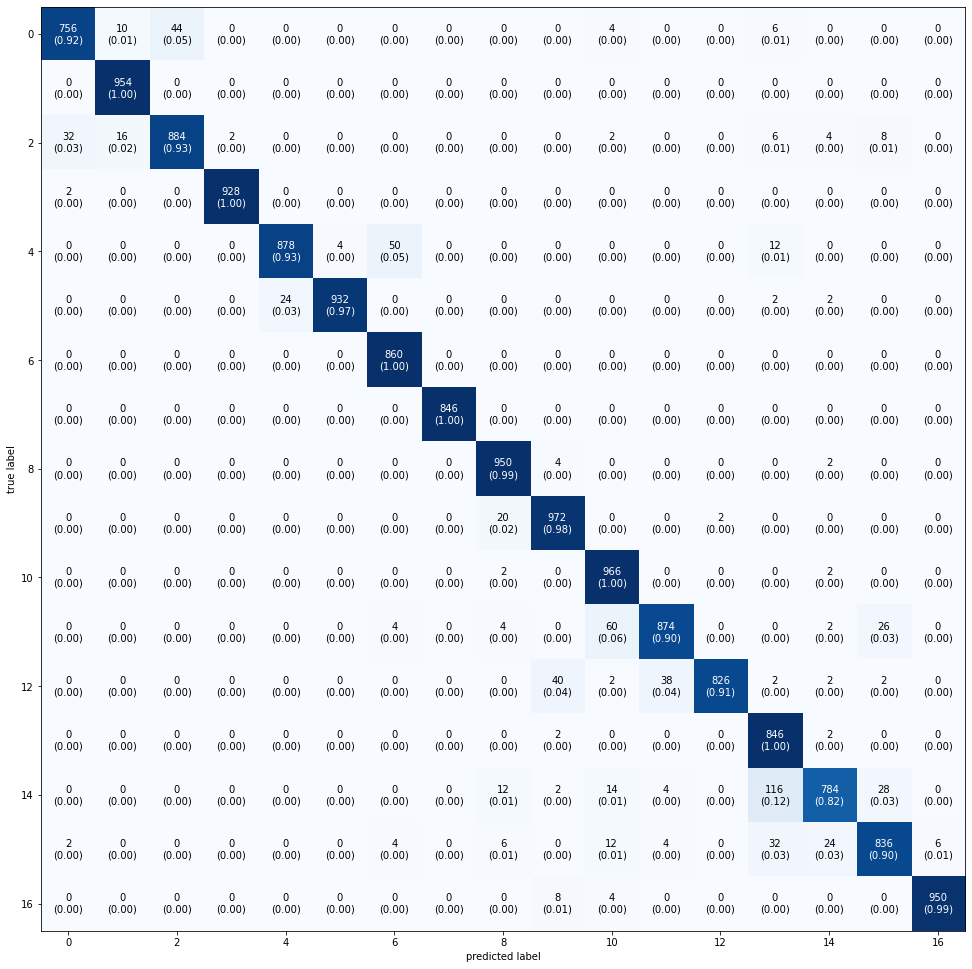

In [18]:
# test the model

for i in range(len(lable_list)):
  print(f"{i} : {lable_list[i]}")

predictions = model.predict_classes(test_generator)

cm = confusion_matrix(test_generator.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(17,17),
                      show_normed=True)

In [21]:
test_accuracy = 0

for i in range(len(lable_list)):
    test_accuracy = test_accuracy + cm[i, i]
   
accuracy = test_accuracy /15768

   
print("Test Accuracy: {}%".format(round(accuracy * 100, 3)))


Test Accuracy: 95.396%
